# Imports:

In [1]:
from microscope import *
import ipywidgets as widgets

%matplotlib inline

# Interactive simulation:

### Analytical Cavity:

In [ ]:
l_1 = 1064e-9
l_2 = 532e-9
pixel_size = 1e-10
N_POINTS = 128  # Resolution of image

input_coordinate_system = CoordinateSystem(dxdydz=(pixel_size, pixel_size), n_points=(N_POINTS, N_POINTS))
first_wave = WaveFunction(psi=np.ones((N_POINTS, N_POINTS)),
                          coordinates=input_coordinate_system,
                          E_0=Joules_of_keV(300))

dummy_sample = SamplePropagator(dummy_potential=f'letters_{N_POINTS}',
                                coordinates_for_dummy_potential=CoordinateSystem(axes=(input_coordinate_system.x_axis,
                                                                                       input_coordinate_system.y_axis,
                                                                                       np.linspace(-5e-10, 5e-10, 2)
                                                                                       )))


power_1_default = find_power_for_phase(starting_power=1e3, cavity_type='analytical', print_progress=False, NA_1=0.05)
def f(NA_1=0.05, defocus_nm=0, Cs_mm=0, n_electrons=20, ring_cavity=True, power_1=power_1_default, focal_length_mm=2):
    first_lens = LensPropagator(focal_length=focal_length_mm*1e-3, fft_shift=True)
    cavity = CavityAnalyticalPropagator(l_1=l_1, l_2=l_2, power_1=power_1, power_2=None, NA_1=NA_1, ring_cavity=ring_cavity)
    second_lens = LensPropagator(focal_length=focal_length_mm*1e-3, fft_shift=False)
    aberration_propagator = AberrationsPropagator(Cs=Cs_mm*1e-3, defocus=defocus_nm*1e-9, astigmatism_parameter=0, astigmatism_orientation=0)
    M = Microscope([dummy_sample, first_lens, cavity, second_lens, aberration_propagator], n_electrons_per_square_angstrom=n_electrons)
    pic = M.take_a_picture(first_wave)

    fig, ax = plt.subplots(2, 2, figsize=(14, 14))
    # fig = plt.figure(figsize=(14, 10))
    mask = cavity.load_or_calculate_phase_and_amplitude_mask(M.step_of_propagator(cavity).output_wave)
    middle_phase_mask_value = mask[mask.shape[0] // 2, mask.shape[1] // 2]
    attenuation_factor = np.abs(middle_phase_mask_value)
    phase_factor = np.real(np.angle(middle_phase_mask_value))
#     plt.suptitle(f' phase_factor over pi{phase_factor / np.pi:.2f} {attenuation_factor=:.2f}')
#     plt.imshow(pic_2f_a.values, extent=pic_2f_a.coordinates.limits)
#     plt.colorbar()
    
    im_intensity = ax[0,0].imshow(pic.values, extent=pic.coordinates.limits)
    ax[0,0].set_title(f"Image")
    divider = make_axes_locatable(ax[0,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_intensity, cax=cax, orientation="vertical")
    
    output_wave = M.step_of_propagator(aberration_propagator).output_wave
    image_fourier_plane = np.fft.fft2(output_wave.psi)
    fft_freq_x = np.fft.fftfreq(output_wave.psi.shape[0], output_wave.coordinates.dxdydz[0])
    fft_freq_x = np.fft.fftshift(fft_freq_x)
    image_fourier_plane = np.clip(np.abs(image_fourier_plane), a_min=0, a_max=np.percentile(np.abs(image_fourier_plane), 99))
    im_fourier = ax[0,1].imshow(np.abs(image_fourier_plane), extent = (fft_freq_x[0], fft_freq_x[-1], fft_freq_x[0], fft_freq_x[-1]))
    ax[0,1].set_title(f"Image - Fourier")
    divider = make_axes_locatable(ax[0,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_fourier, cax=cax, orientation="vertical")

    mask_phase = ax[1,0].imshow(np.angle(mask), extent=M.step_of_propagator(cavity).input_wave.coordinates.limits)
    ax[1,0].set_title(f"mask - phase")
    divider = make_axes_locatable(ax[1,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mask_phase, cax=cax, orientation="vertical")
    
    mask_attenuation = ax[1,1].imshow(np.abs(mask), extent=M.step_of_propagator(cavity).input_wave.coordinates.limits)
    ax[1,1].set_title(f"mask - amplitude transfer")
    divider = make_axes_locatable(ax[1,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mask_attenuation, cax=cax, orientation="vertical",)

    return phase_factor, attenuation_factor

I = widgets.interactive(f, NA_1=(0.001, 0.2, 0.01), defocus_nm=(-200, 200, 1), Cs_mm=(0, 5, 0.01), n_electrons=(0, 100, 1), ring_cavity=True, power_1=(0, power_1_default * 2, power_1_default / 100), focal_length_mm=(1, 6, 0.1));
button = widgets.Button(description="Save Image")

display(button)
display(I)


def on_button_clicked(b):
    d = dict(zip([s.description for s in I.children[:-1]], [s.value for s in I.children[:-1]]))
    phase_factor, attenuation_factor = f(**d)
    text_to_add = f' phase_factor over pi{phase_factor / np.pi:.2f} {attenuation_factor=:.2f}'
    title = "".join([f'{key}= {value:.2e} ' if isinstance(value, float) else f'{key}= {value} '  for key, value in d.items()])
    title += text_to_add
    plt.title(title)
    plt.savefig(f"examples\\{title}.png")
    plt.close()
button.on_click(on_button_clicked)

### Numerical Cavity

In [3]:
power_1_default = find_power_for_phase(starting_power=1e3, cavity_type='numerical', print_progress=False, NA_1=0.05, n_z=10000, theta_polarization=0.5*np.pi, ring_cavity=True)

Calculating layers 1-3 out of 3 in axis 2
Calculating layers 1-3 out of 3 in axis 2


In [4]:
def f(NA_1=0.05, second_laser=True,
      ring_cavity=True, polarization_pies=1/2, E_0=300, defocus_nm=0, 
      Cs_mm=0.3, n_electrons=20, power_1=power_1_default,
      focal_length_mm=3.3, alpha_cavity_deviation_degrees=0, resolution=256, pixel_size=2e-10, n_z=None):
    first_lens = LensPropagator(focal_length=focal_length_mm*1e-3, fft_shift=True)
    if second_laser:
        power_2 = -1
    else:
        power_2 = None

    l_1 = 1064e-9
    l_2 = 532e-9

    input_wave_full = WaveFunction(E_0=Joules_of_keV(E_0), mrc_file_path=r'Data Arrays\Static Data\apof.mrc')
    input_wave = WaveFunction(E_0=input_wave_full.E_0, psi=input_wave_full.psi[150:150+resolution, 150:150+resolution], coordinates=CoordinateSystem(dxdydz=(pixel_size, pixel_size), n_points=(resolution, resolution)))

    # dummy_sample = SamplePropagator(dummy_potential=f'letters_{N_POINTS}',
    #                                 coordinates_for_dummy_potential=CoordinateSystem(axes=(input_coordinate_system.x_axis,
    #                                                                                        input_coordinate_system.y_axis,
    #                                                                                        np.linspace(-5e-10, 5e-10, 2)
    #                                                                                        )))

    cavity = CavityNumericalPropagator(l_1=l_1, l_2=l_2, power_1=power_1, power_2=power_2, NA_1=NA_1, ring_cavity=ring_cavity,
                                      alpha_cavity_deviation = alpha_cavity_deviation_degrees / 360 * 2*np.pi, theta_polarization=polarization_pies*np.pi,
                                      n_z=n_z)
    second_lens = LensPropagator(focal_length=focal_length_mm*1e-3, fft_shift=False)
    aberration_propagator = AberrationsPropagator(Cs=Cs_mm*1e-3, defocus=defocus_nm*1e-9, astigmatism_parameter=0, astigmatism_orientation=0)
    M = Microscope([first_lens, cavity, second_lens, aberration_propagator], n_electrons_per_square_angstrom=n_electrons)
    pic = M.take_a_picture(input_wave)

    fig, ax = plt.subplots(2, 3, figsize=(21, 14))
    mask = cavity.load_or_calculate_phase_and_amplitude_mask(M.step_of_propagator(cavity).output_wave)
    middle_phase_mask_value = mask[mask.shape[0] // 2, mask.shape[1] // 2]
    attenuation_factor = np.abs(middle_phase_mask_value)
    phase_factor = np.real(np.angle(middle_phase_mask_value))
#     plt.suptitle(f' phase_factor over pi{phase_factor / np.pi:.2f} {attenuation_factor=:.2f}')
#     plt.imshow(pic_2f_a.values, extent=pic_2f_a.coordinates.limits)
#     plt.colorbar()
    
    im_intensity = ax[0,1].imshow(np.flip(pic.values), extent=input_wave.coordinates.limits)
    ax[0,1].set_title(f"Image")
    divider = make_axes_locatable(ax[0,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_intensity, cax=cax, orientation="vertical")
    
    output_wave = M.step_of_propagator(aberration_propagator).output_wave
    image_fourier_plane = np.fft.fft2(output_wave.psi)
    fft_freq_x = np.fft.fftfreq(output_wave.psi.shape[0], output_wave.coordinates.dxdydz[0])
    fft_freq_x = np.fft.fftshift(fft_freq_x)
    image_fourier_plane = np.clip(np.abs(image_fourier_plane), a_min=0, a_max=np.percentile(np.abs(image_fourier_plane), 99))
    im_fourier = ax[1,1].imshow(np.abs(image_fourier_plane), extent = (fft_freq_x[0], fft_freq_x[-1], fft_freq_x[0], fft_freq_x[-1]))
    ax[1,1].set_title(f"Image - Fourier")
    divider = make_axes_locatable(ax[1,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_fourier, cax=cax, orientation="vertical")

    mask_phase = ax[0,0].imshow(np.angle(input_wave.psi), extent=input_wave.coordinates.limits)
    ax[0,0].set_title(f"Original wave - phase")
    divider = make_axes_locatable(ax[0,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mask_phase, cax=cax, orientation="vertical")
    
    mask_attenuation = ax[1,0].imshow(np.abs(input_wave.psi)**2, extent=input_wave.coordinates.limits)
    ax[1,0].set_title(f"Original image - Intensity")
    divider = make_axes_locatable(ax[1,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mask_attenuation, cax=cax, orientation="vertical")
    
    mask_phase = ax[0,2].imshow(np.angle(mask), extent=M.step_of_propagator(cavity).input_wave.coordinates.limits)
    ax[0,2].set_title(f"mask - phase")
    divider = make_axes_locatable(ax[0,2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mask_phase, cax=cax, orientation="vertical")
    
    mask_attenuation = ax[1,2].imshow(np.abs(mask)**2, extent=M.step_of_propagator(cavity).input_wave.coordinates.limits)
    ax[1,2].set_title(f"mask - intensity transfer")
    divider = make_axes_locatable(ax[1,2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mask_attenuation, cax=cax, orientation="vertical")
    
    return phase_factor, attenuation_factor

I = widgets.interactive(f,
                        NA_1=[0.02, 0.05, 0.08, 0.1, 0.15, 0.2],
                        second_laser=True,
                        ring_cavity=True,
                        polarization_pies=list(np.linspace(0, 1/2, 5, endpoint=True)),
                        E_0=(0, 300, 1),
                        defocus_nm=(-200, 200, 1),
                        Cs_mm=(0, 5, 0.01),
                        n_electrons=(0, 100, 1),
                        power_1=(0,3*power_1_default, power_1_default / 400),
                        focal_length_mm=(1, 6, 0.1),
                        alpha_cavity_deviation_degrees = (-40, 40, 1),
                        resolution=[32, 64, 128, 256, 1024],
                        pixel_size=[1e-10, 2e-10, 5e-10, 1e-9, 5e-9, 1e-8, 5e-8],
                        n_z = [None, 100, 150, 160, 170, 180, 190, 200, 300, 500, 6000, 8000, 10000, 15000, 20000]);
button = widgets.Button(description="Save Image")

display(button)
display(I)


def on_button_clicked(b):
    d = dict(zip([s.description for s in I.children[:-1]], [s.value for s in I.children[:-1]]))
    phase_factor, attenuation_factor = f(**d)
    text_to_add = f' phase_factor over pi{phase_factor / np.pi:.2f} {attenuation_factor=:.2f}'
    # title = "".join([f'{key}= {value:.2e} ' if isinstance(value, float) else f'{key}= {value} ' for key, value in d.items()])
    # title# += text_to_add
    title_a = f"NA={d['NA_1']:.2f}, ring_cavity={d['ring_cavity']}, polarization_pies={d['polarization_pies']:.2f}, E_0={d['E_0']:.0f}, defocus_nm={d['defocus_nm']:.0f}, Cs_mm={d['Cs_mm']:.2f}, n_electrons={d['n_electrons']:.0f}"
    title_b = f"alpha_cavity_deviation_degrees={d['alpha_cavity_deviation_degrees']}, power_1={d['power_1']:.2e}"
    plt.suptitle(f"{title_a}\n{title_b}")
    file_name = f"Figures\\examples\\{title_a}, {title_b}.png" 
    plt.savefig(file_name)
    plt.close()
button.on_click(on_button_clicked)

Button(description='Save Image', style=ButtonStyle())

interactive(children=(Dropdown(description='NA_1', index=1, options=(0.02, 0.05, 0.08, 0.1, 0.15, 0.2), value=…

### Ideal Cavity:

In [ ]:
def f(infinitesimal_mask, radius_microns, mask_phase_in_pies=0.5, mask_attenuation=0, defocus_nm=0, Cs_nm=0, n_electrons=20, focal_length_mm=3.3):
    if infinitesimal_mask:
        r = -1
    else:
        r = radius_microns * 1e-6

    first_lens = LensPropagator(focal_length=focal_length_mm*1e-3, fft_shift=True)
    cavity = DummyPhaseMask(mask_width_meters=r, mask_phase=-mask_phase_in_pies * np.pi, mask_attenuation=mask_attenuation)
    second_lens = LensPropagator(focal_length=focal_length_mm*1e-3, fft_shift=False)
    aberration_propagator = AberrationsPropagator(Cs=Cs_nm*1e-9, defocus=defocus_nm*1e-9, astigmatism_parameter=0, astigmatism_orientation=0)

    M = Microscope([dummy_sample, first_lens, cavity, second_lens, aberration_propagator], n_electrons_per_square_angstrom=n_electrons)
    pic = M.take_a_picture(first_wave)
    
    mask = cavity.generate_dummy_potential(M.step_of_propagator(cavity).input_wave)
    
    fig, ax = plt.subplots(2, 2, figsize=(22, 22))
    attenuation_factor = mask_attenuation
    phase_factor = mask_phase_in_pies
    plt.title(f' phase_factor over pi{phase_factor:.2f} {attenuation_factor=:.2f}')
    
    im_intensity = ax[0,0].imshow(pic.values, extent=pic.coordinates.limits)
    ax[0,0].set_title(f"Image")
    divider = make_axes_locatable(ax[0,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_intensity, cax=cax, orientation="vertical")
    
    output_wave = M.step_of_propagator(aberration_propagator).output_wave
    image_fourier_plane = np.fft.fft2(output_wave.psi)
    fft_freq_x = np.fft.fftfreq(output_wave.psi.shape[0], output_wave.coordinates.dxdydz[0])
    fft_freq_x = np.fft.fftshift(fft_freq_x)
    image_fourier_plane = np.clip(np.abs(image_fourier_plane), a_min=0, a_max=np.percentile(np.abs(image_fourier_plane), 99))
    im_fourier = ax[0,1].imshow(np.abs(image_fourier_plane), extent = (fft_freq_x[0], fft_freq_x[-1], fft_freq_x[0], fft_freq_x[-1]))
    ax[0,1].set_title(f"Image - Fourier")
    divider = make_axes_locatable(ax[0,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_fourier, cax=cax, orientation="vertical")

    mask_phase = ax[1,0].imshow(np.angle(mask), extent=M.step_of_propagator(cavity).input_wave.coordinates.limits)
    ax[1,0].set_title(f"mask - phase")
    divider = make_axes_locatable(ax[1,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mask_phase, cax=cax, orientation="vertical")
    
    mask_attenuation = ax[1,1].imshow(np.abs(mask), extent=M.step_of_propagator(cavity).input_wave.coordinates.limits)
    ax[1,1].set_title(f"mask - amplitude transfer")
    divider = make_axes_locatable(ax[1,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mask_attenuation, cax=cax, orientation="vertical")

I = widgets.interactive(f, infinitesimal_mask=False, radius_microns=(0, 20, 0.2), mask_phase_in_pies=(0, 2, 0.1), mask_attenuation=(0,1, 0.01), defocus_nm=(-100, 100, 1), Cs_nm=(0, 100, 1), n_electrons=(0, 300, 2), ring_cavity=True, focal_length_mm=(1, 6, 0.1));
button = widgets.Button(description="Save Image")

display(button)
display(I)


def on_button_clicked(b):
    d = dict(zip([s.description for s in I.children[:-1]], [s.value for s in I.children[:-1]]))
    phase_factor, attenuation_factor = f(**d)
    if d['infinitesimal_mask']:
        mask_width='eps'
    else:
        mask_width=f"{d['radius_microns']:.2f}"
    title = f'phase_factor in pies={phase_factor:.2f} attenuation_factor={attenuation_factor:.2f} mask_width_microns={mask_width}defocus_nm={d["defocus_nm"]} Cs_nm={d["Cs_nm"]} n_electrons={d["n_electrons"]}'
    plt.title(title)
    plt.savefig(f"examples\\{title}.png")
    plt.close()
button.on_click(on_button_clicked)

# Generate and save many plots at once:

In [ ]:
N_POINTS = 256  # Resolution of image
pixel_size = 1e-10
# %%
input_coordinate_system = CoordinateSystem(dxdydz=(pixel_size, pixel_size), n_points=(N_POINTS, N_POINTS))
first_wave = WaveFunction(psi=np.ones((N_POINTS, N_POINTS)),
                          coordinates=input_coordinate_system,
                          E_0=Joules_of_keV(300))

dummy_sample = SamplePropagator(dummy_potential=f'letters_{N_POINTS}',
                                coordinates_for_dummy_potential=CoordinateSystem(axes=(input_coordinate_system.x_axis,
                                                                                       input_coordinate_system.y_axis,
                                                                                       np.linspace(-5e-10, 5e-10, 2)
                                                                                       )))


first_lens = LensPropagator(focal_length=3.3e-3, fft_shift=True)
second_lens = LensPropagator(focal_length=3.3e-3, fft_shift=False)

for ring_cavity in [True, False]:
    for cavity_propagator in [CavityNumericalPropagator]:   # CavityAnalyticalPropagator
        for NA_1 in [0.05, 0.08, 0.1, 0.15, 0.2]:  #
            for power_2 in [-1, None]:  # (with and without a second laser)
                for Cs in [0, 1e-8, 5e-8]:
                    for defocus in [-1e-7, -5e-8, -1e-8, 1e-8, 5e-8, 1e-8]:
                        if cavity_propagator.__name__ == 'CavityAnalyticalPropagator':
                            cavity_name = 'Analytical'
                        else:
                            cavity_name = 'Numerical'
                        if power_2 == -1:
                            two_lasers = 'True'
                        else:
                            two_lasers = 'False'
                        title = f'NA_1={NA_1}, ring_cavity={ring_cavity}, type={cavity_name},' \
                                f'two_lasers={two_lasers}, Cs={Cs}, defocus={defocus}'
                        print(f"Calculating {title}...", end='\r')
                        C = cavity_propagator(NA_1=NA_1, ring_cavity=ring_cavity, power_2=power_2, ignore_past_files=True)
                        aberrations_propagator = AberrationsPropagator(Cs=Cs, defocus=defocus)
                        M = Microscope([dummy_sample, first_lens, C, second_lens, aberrations_propagator])
                        pic = M.take_a_picture(first_wave)
                        plt.imshow(pic.values, extent=input_coordinate_system.limits)
                        plt.title(title)
                        # plt.savefig(f'Figures\\{title}.png')
                        print(f"Calculating {title} - finished")
print("finished")

# Compare effective cavity phase masks:

for power_1 = 6.6e+04 the resulted phase is -0.50pi=-1.57 rads
for power_1 = 8.3e+05 the resulted phase is -0.50pi=-1.57 rads
Calculating layers 1-3 out of 3 in axis 2
Calculating layers 1-3 out of 3 in axis 2
for power_1 = 5.7e+04 the resulted phase is -0.50pi=-1.57 rads
Calculating layers 1-3 out of 3 in axis 2
Calculating layers 1-3 out of 3 in axis 2
for power_1 = 1.1e+05 the resulted phase is -0.50pi=-1.57 rads
Calculating layers 1-3 out of 3 in axis 2
Calculating layers 1-3 out of 3 in axis 2


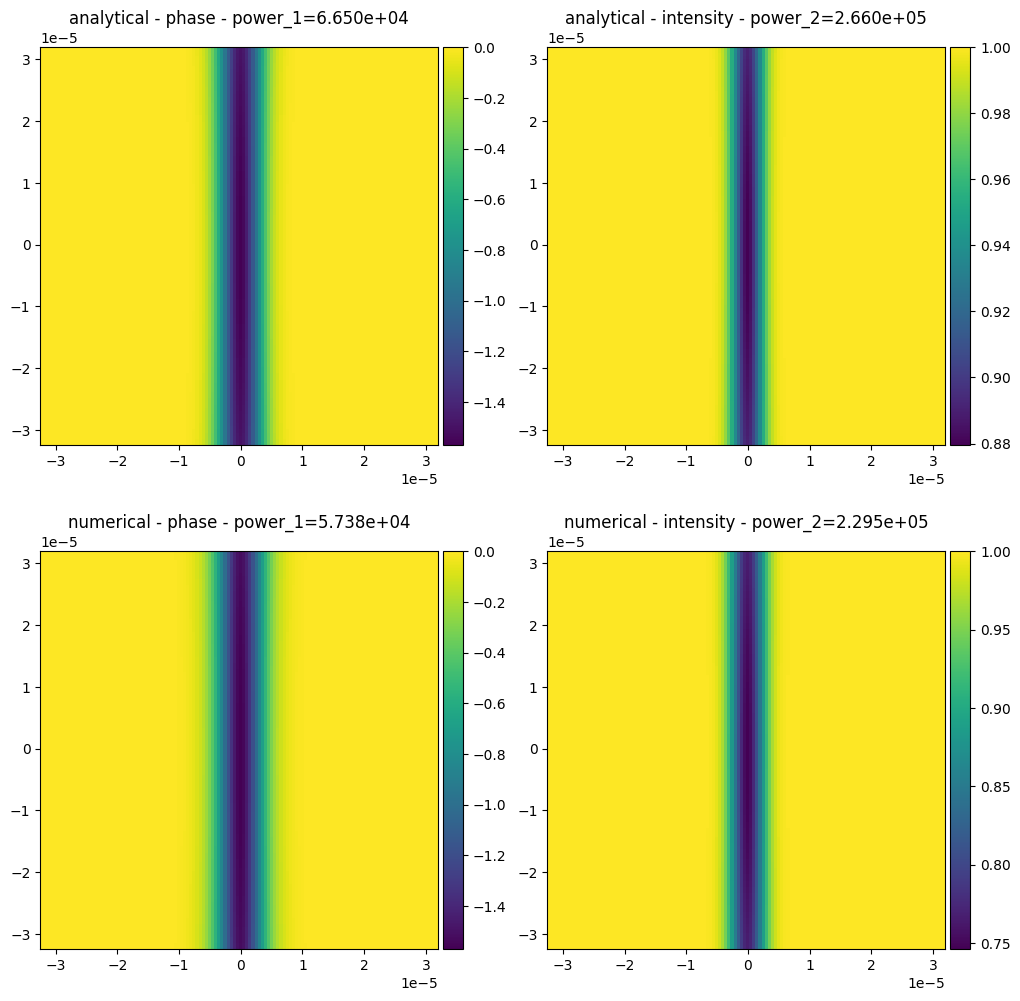

power_1_numerical / power_1_analytical = f1.15e+05 / 8.31e+05 = 0.14


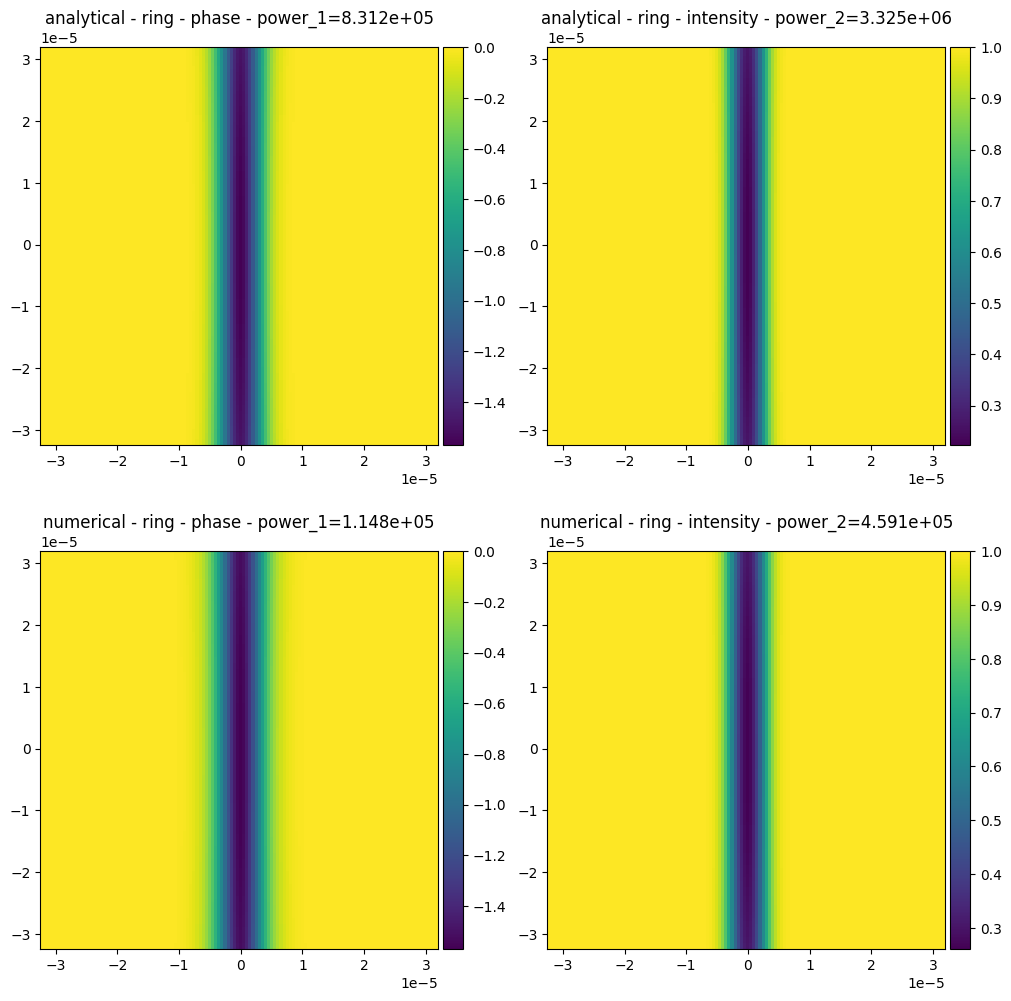

In [13]:
N_POINTS = 128  # Resolution of image
l_1 = 1064e-9
l_2 = 532e-9
NA_1 = 0.05
pixel_size = 1e-10
E_0 = Joules_of_keV(300)
theta_polarization= 1/2 * np.pi
input_coordinate_system = CoordinateSystem(dxdydz=(pixel_size, pixel_size), n_points=(N_POINTS, N_POINTS))
first_wave = WaveFunction(psi=np.ones((N_POINTS, N_POINTS)),
                          coordinates=input_coordinate_system,
                          E_0=E_0)

first_lens = LensPropagator(focal_length=3.3e-3, fft_shift=True)


cavity_2f_analytical = CavityAnalyticalPropagator(l_1=l_1, l_2=l_2, power_1=-1, NA_1=NA_1, ring_cavity=False, theta_polarization=theta_polarization, input_wave_energy_for_power_finding=E_0)
cavity_2f_analytical_ring = CavityAnalyticalPropagator(l_1=l_1, l_2=l_2, power_1=-1, NA_1=NA_1, ring_cavity=True, theta_polarization=theta_polarization, input_wave_energy_for_power_finding=E_0)
cavity_2f_numerical = CavityNumericalPropagator(l_1=l_1, l_2=l_2, power_1=-1, NA_1=NA_1, ring_cavity=False, n_z=10000, theta_polarization=theta_polarization, input_wave_energy_for_power_finding=E_0)
cavity_2f_numerical_ring = CavityNumericalPropagator(l_1=l_1, l_2=l_2, power_1=-1, NA_1=NA_1, ring_cavity=True, n_z=10000, theta_polarization=theta_polarization, input_wave_energy_for_power_finding=E_0)

asd = 1
cavity_2f_analytical.power_1 *= asd
cavity_2f_analytical_ring.power_1  *= asd
cavity_2f_numerical.power_1  *= asd
cavity_2f_numerical_ring.power_1  *= asd
cavity_2f_analytical.power_2 *= asd
cavity_2f_analytical_ring.power_2  *= asd
cavity_2f_numerical.power_2  *= asd
cavity_2f_numerical_ring.power_2  *= asd


fourier_plane_wave = first_lens.propagate(first_wave)

phase_and_amplitude_mask_a = cavity_2f_analytical.load_or_calculate_phase_and_amplitude_mask(fourier_plane_wave)
phase_and_amplitude_mask_a_ring = cavity_2f_analytical_ring.load_or_calculate_phase_and_amplitude_mask(fourier_plane_wave)
phase_and_amplitude_mask_n = cavity_2f_numerical.load_or_calculate_phase_and_amplitude_mask(fourier_plane_wave)
phase_and_amplitude_mask_n_ring = cavity_2f_numerical_ring.load_or_calculate_phase_and_amplitude_mask(fourier_plane_wave)

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
im1 = ax1.imshow(np.real(np.angle(phase_and_amplitude_mask_a)), extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax1)
ax1.set_title(f'analytical - phase - power_1={cavity_2f_analytical.power_1:.3e}')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(np.abs(phase_and_amplitude_mask_a)**2, extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax2)
ax2.set_title(f'analytical - intensity - power_2={cavity_2f_analytical.power_2:.3e}')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(np.real(np.angle(phase_and_amplitude_mask_n)), extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax3)
ax3.set_title(f'numerical - phase - power_1={cavity_2f_numerical.power_1:.3e}')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(np.abs(phase_and_amplitude_mask_n)**2, extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax4)
ax4.set_title(f'numerical - intensity - power_2={cavity_2f_numerical.power_2:.3e}')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical')
plt.show()

print(f"power_1_numerical / power_1_analytical = f{cavity_2f_numerical_ring.power_1:.2e} / {cavity_2f_analytical_ring.power_1:.2e} = {cavity_2f_numerical_ring.power_1 / cavity_2f_analytical_ring.power_1:.2f}")

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
im1 = ax1.imshow(np.real(np.angle(phase_and_amplitude_mask_a_ring)), extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax1)
ax1.set_title(f'analytical - ring - phase - power_1={cavity_2f_analytical_ring.power_1:.3e}')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(np.abs(phase_and_amplitude_mask_a_ring)**2, extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax2)
ax2.set_title(f'analytical - ring - intensity - power_2={cavity_2f_analytical_ring.power_2:.3e}')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(np.real(np.angle(phase_and_amplitude_mask_n_ring)), extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax3)
ax3.set_title(f'numerical - ring - phase - power_1={cavity_2f_numerical_ring.power_1:.3e}')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(np.abs(phase_and_amplitude_mask_n_ring)**2, extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax4)
ax4.set_title(f'numerical - ring - intensity - power_2={cavity_2f_numerical_ring.power_2:.3e}')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical')
plt.show()

In [35]:
power_1_default = find_power_for_phase(starting_power=1e3, cavity_type='numerical', print_progress=False, NA_1=0.05, n_z=10000, theta_polarization=0.5*np.pi, ring_cavity=True)
def f(NA_1=0.05, second_laser=True,
      ring_cavity=True, polarization_pies=1/2, E_0=300, defocus_nm=0, 
      Cs_mm=0, n_electrons=20, power_1=power_1_default,
      focal_length_mm=3.3, alpha_cavity_deviation_degrees=0, resolution=32, pixel_size=2e-10, n_z=1000):
    first_lens = LensPropagator(focal_length=focal_length_mm*1e-3, fft_shift=True)
    if second_laser:
        power_2 = -1
    else:
        power_2 = None

    l_1 = 1064e-9
    l_2 = 532e-9

    input_coordinate_system = CoordinateSystem(dxdydz=(pixel_size, pixel_size), n_points=(resolution, resolution))
    input_wave_full = WaveFunction(E_0=Joules_of_keV(E_0), mrc_file_path=r'Data Arrays\Static Data\apof.mrc')
    input_wave = WaveFunction(E_0=input_wave_full.E_0, psi=input_wave_full.psi[150:150+resolution, 150:150+resolution], coordinates=CoordinateSystem(dxdydz=input_wave_full.coordinates.dxdydz, n_points=(resolution, resolution)))

    # dummy_sample = SamplePropagator(dummy_potential=f'letters_{N_POINTS}',
    #                                 coordinates_for_dummy_potential=CoordinateSystem(axes=(input_coordinate_system.x_axis,
    #                                                                                        input_coordinate_system.y_axis,
    #                                                                                        np.linspace(-5e-10, 5e-10, 2)
    #                                                                                        )))

    cavity = CavityNumericalPropagator(l_1=l_1, l_2=l_2, power_1=power_1, power_2=power_2, NA_1=NA_1, ring_cavity=ring_cavity,
                                      alpha_cavity_deviation = alpha_cavity_deviation_degrees / 360 * 2*np.pi, theta_polarization=polarization_pies*np.pi,
                                      n_z=int(n_z))
    second_lens = LensPropagator(focal_length=focal_length_mm*1e-3, fft_shift=False)
    aberration_propagator = AberrationsPropagator(Cs=Cs_mm*1e-3, defocus=defocus_nm*1e-9, astigmatism_parameter=0, astigmatism_orientation=0)
    M = Microscope([first_lens, cavity, second_lens, aberration_propagator], n_electrons_per_square_angstrom=n_electrons)
    pic = M.take_a_picture(input_wave)

    fig, ax = plt.subplots(1, 2, figsize=(21, 14))
    mask = cavity.load_or_calculate_phase_and_amplitude_mask(M.step_of_propagator(cavity).output_wave)
    middle_phase_mask_value = mask[mask.shape[0] // 2, mask.shape[1] // 2]
    attenuation_factor = np.abs(middle_phase_mask_value)
    phase_factor = np.real(np.angle(middle_phase_mask_value))
    
    mask_phase = ax[0].imshow(np.angle(mask), extent=M.step_of_propagator(cavity).input_wave.coordinates.limits)
    ax[0].set_title(f"mask - phase")
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mask_phase, cax=cax, orientation="vertical")
    
    mask_attenuation = ax[1].imshow(np.abs(mask)**2, extent=M.step_of_propagator(cavity).input_wave.coordinates.limits)
    ax[1].set_title(f"mask - intensity transfer")
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mask_attenuation, cax=cax, orientation="vertical")
    
    return print(phase_factor, attenuation_factor)

I = widgets.interactive(f,
                        NA_1=[0.02, 0.05, 0.08, 0.1, 0.15, 0.2],
                        second_laser=True,
                        ring_cavity=True,
                        polarization_pies=list(np.linspace(0, 1/2, 5, endpoint=True)),
                        E_0=(0, 300, 1),
                        defocus_nm=(-200, 200, 1),
                        Cs_mm=(0, 5, 0.01),
                        n_electrons=(0, 100, 1),
                        power_1=(0,power_1_default * 2, power_1_default / 100),
                        focal_length_mm=(1, 6, 0.1),
                        alpha_cavity_deviation_degrees = (-40, 40, 1),
                        resolution=[32, 64, 128, 256, 1024],
                        pixel_size=[1e-10, 2e-10, 5e-10, 1e-9, 5e-9, 1e-8, 5e-8],
                        n_z = (50, 2000, 50));
button = widgets.Button(description="Save Image")

display(button)
display(I)


def on_button_clicked(b):
    d = dict(zip([s.description for s in I.children[:-1]], [s.value for s in I.children[:-1]]))
    phase_factor, attenuation_factor = f(**d)
    text_to_add = f' phase_factor over pi{phase_factor / np.pi:.2f} {attenuation_factor=:.2f}'
    title = "".join([f'{key}= {value:.2e} ' if isinstance(value, float) else f'{key}= {value} '  for key, value in d.items()])
    title += text_to_add
    plt.title(title)
    plt.savefig(f"examples\\{title}.png")
    plt.close()
button.on_click(on_button_clicked)

Calculating layers 1-3 out of 3 in axis 2
Calculating layers 1-3 out of 3 in axis 2


Button(description='Save Image', style=ButtonStyle())

interactive(children=(Dropdown(description='NA_1', index=1, options=(0.02, 0.05, 0.08, 0.1, 0.15, 0.2), value=…